# Notebook 01: Why Parallelism Matters

## Topic 1: Motivation & Core Concepts

In this notebook, we'll explore:
1. Why your code might be slow
2. The difference between sequential and parallel execution
3. A first taste of parallel speedup in a finance context

---

## Setup

First, let's import the libraries we'll need:

In [1]:
import numpy as np
import time
import os
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor

# Check how many CPU cores we have
print(f"This machine has {os.cpu_count()} CPU cores")
print(f"NumPy version: {np.__version__}")

This machine has 16 CPU cores
NumPy version: 1.24.3


---

## 1. The Problem: Sequential Code is Slow

### Example: Monte Carlo Simulation for Option Pricing

In finance, we often need to run many simulations. Let's start with a simple example: estimating the price of a European call option using Monte Carlo simulation.

**The Black-Scholes-Merton model** tells us that stock prices follow geometric Brownian motion:

$$S_T = S_0 \exp\left[\left(r - \frac{\sigma^2}{2}\right)T + \sigma\sqrt{T}Z\right]$$

Where:
- $S_0$ = current stock price
- $r$ = risk-free rate
- $\sigma$ = volatility
- $T$ = time to maturity
- $Z$ = standard normal random variable

In [2]:
def price_european_call_sequential(S0, K, T, r, sigma, n_simulations):
    """
    Price a European call option using Monte Carlo simulation.
    
    Parameters:
    -----------
    S0 : float - Current stock price
    K : float - Strike price
    T : float - Time to maturity (years)
    r : float - Risk-free rate
    sigma : float - Volatility
    n_simulations : int - Number of Monte Carlo paths
    
    Returns:
    --------
    float - Estimated option price
    """
    # Generate random normal samples
    Z = np.random.standard_normal(n_simulations)
    
    # Simulate terminal stock prices
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    
    # Calculate payoffs
    payoffs = np.maximum(ST - K, 0)
    
    # Discounted expected payoff
    option_price = np.exp(-r * T) * np.mean(payoffs)
    
    return option_price

In [3]:
# Option parameters
S0 = 100      # Current stock price
K = 100       # Strike price (at-the-money)
T = 1.0       # 1 year to maturity
r = 0.05      # 5% risk-free rate
sigma = 0.2   # 20% volatility
n_sims = 1_000_000  # 1 million simulations

# Time a single option pricing
start = time.time()
price = price_european_call_sequential(S0, K, T, r, sigma, n_sims)
elapsed = time.time() - start

print(f"Option Price: ${price:.4f}")
print(f"Time taken: {elapsed:.3f} seconds")

Option Price: $10.4639
Time taken: 0.043 seconds


### Now imagine pricing many options...

In practice, we might need to price hundreds or thousands of options:
- Different strikes for an option chain
- Different maturities
- Different underlyings in a portfolio

In [4]:
# Generate a grid of strike prices
strikes = np.linspace(80, 120, 20)  # 20 different strikes

print(f"We need to price {len(strikes)} options")
print(f"Strikes: {strikes[:5]}... (showing first 5)")

We need to price 20 options
Strikes: [80.         82.10526316 84.21052632 86.31578947 88.42105263]... (showing first 5)


In [5]:
# Sequential pricing of all options
def price_option_chain_sequential(strikes, S0, T, r, sigma, n_sims):
    """Price multiple options sequentially."""
    prices = []
    for K in strikes:
        price = price_european_call_sequential(S0, K, T, r, sigma, n_sims)
        prices.append(price)
    return prices

# Time the sequential version
print("Pricing options sequentially...")
start = time.time()
sequential_prices = price_option_chain_sequential(strikes, S0, T, r, sigma, n_sims)
sequential_time = time.time() - start

print(f"\nSequential time: {sequential_time:.2f} seconds")
print(f"Time per option: {sequential_time/len(strikes):.3f} seconds")

Pricing options sequentially...

Sequential time: 0.97 seconds
Time per option: 0.048 seconds


---

## 2. The Solution: Parallel Execution

Since each option price calculation is **independent**, we can compute them simultaneously on different CPU cores!

We'll use `ProcessPoolExecutor` from the `concurrent.futures` module - Python's high-level interface for parallel execution.

In [6]:
# We need to create a function that takes a single argument for ProcessPoolExecutor
def price_single_option(args):
    """Price a single option - wrapper for parallel execution."""
    S0, K, T, r, sigma, n_sims = args
    return price_european_call_sequential(S0, K, T, r, sigma, n_sims)

def price_option_chain_parallel(strikes, S0, T, r, sigma, n_sims, n_workers=None):
    """Price multiple options in parallel."""
    # Prepare arguments for each option
    args_list = [(S0, K, T, r, sigma, n_sims) for K in strikes]
    
    # Use ProcessPoolExecutor for CPU-bound tasks
    with ProcessPoolExecutor(max_workers=n_workers) as executor:
        prices = list(executor.map(price_single_option, args_list))
    
    return prices

In [7]:
# Time the parallel version
n_workers = os.cpu_count()
print(f"Pricing options in parallel using {n_workers} workers...")

start = time.time()
parallel_prices = price_option_chain_parallel(strikes, S0, T, r, sigma, n_sims, n_workers)
parallel_time = time.time() - start

print(f"\nParallel time: {parallel_time:.2f} seconds")
print(f"Speedup: {sequential_time / parallel_time:.2f}x faster!")

Pricing options in parallel using 16 workers...

Parallel time: 1.55 seconds
Speedup: 0.63x faster!


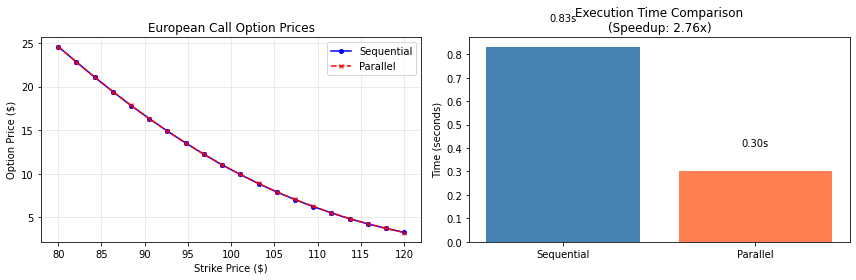

In [8]:
# Verify that results are the same (within Monte Carlo error)
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot option prices
axes[0].plot(strikes, sequential_prices, 'b-o', label='Sequential', markersize=4)
axes[0].plot(strikes, parallel_prices, 'r--x', label='Parallel', markersize=4)
axes[0].set_xlabel('Strike Price ($)')
axes[0].set_ylabel('Option Price ($)')
axes[0].set_title('European Call Option Prices')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot timing comparison
methods = ['Sequential', 'Parallel']
times = [sequential_time, parallel_time]
colors = ['steelblue', 'coral']
bars = axes[1].bar(methods, times, color=colors)
axes[1].set_ylabel('Time (seconds)')
axes[1].set_title(f'Execution Time Comparison\n(Speedup: {sequential_time/parallel_time:.2f}x)')

# Add time labels on bars
for bar, t in zip(bars, times):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                 f'{t:.2f}s', ha='center', va='bottom')

plt.tight_layout()
plt.show()

---

## 3. Understanding the Speedup

### Why did we get this speedup?

1. **Independent tasks**: Each option price calculation doesn't depend on others
2. **CPU-bound work**: The calculations are numerically intensive
3. **Multiple cores**: We distributed work across all available CPU cores

### The theoretical maximum speedup

If we have $n$ cores and the work is perfectly parallelizable:
- Theoretical speedup = $n$
- In practice, we get less due to overhead (creating processes, combining results)

In [9]:
# Let's measure speedup with different numbers of workers
def benchmark_workers(strikes, S0, T, r, sigma, n_sims, max_workers=None):
    """Benchmark parallel execution with different worker counts."""
    if max_workers is None:
        max_workers = os.cpu_count()
    
    results = {}
    
    for n_workers in range(1, max_workers + 1):
        start = time.time()
        _ = price_option_chain_parallel(strikes, S0, T, r, sigma, n_sims, n_workers)
        elapsed = time.time() - start
        results[n_workers] = elapsed
        print(f"Workers: {n_workers}, Time: {elapsed:.2f}s")
    
    return results

print("Benchmarking with different worker counts...\n")
worker_results = benchmark_workers(strikes, S0, T, r, sigma, n_sims)

Benchmarking with different worker counts...

Workers: 1, Time: 0.93s
Workers: 2, Time: 0.50s
Workers: 3, Time: 0.34s
Workers: 4, Time: 0.30s
Workers: 5, Time: 0.30s
Workers: 6, Time: 0.27s
Workers: 7, Time: 0.26s
Workers: 8, Time: 0.28s


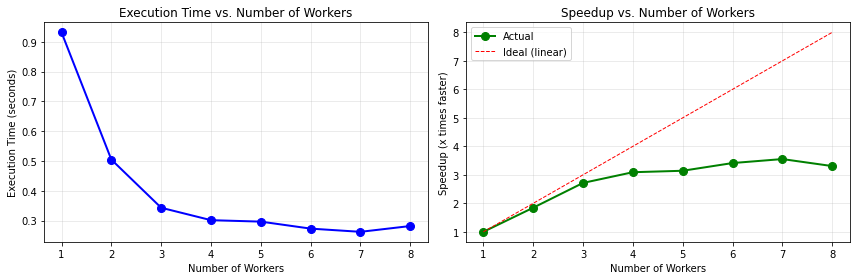


Efficiency with 8 workers: 41.3%


In [10]:
# Plot the scaling results
workers = list(worker_results.keys())
times = list(worker_results.values())
baseline = times[0]  # Time with 1 worker
speedups = [baseline / t for t in times]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Execution time vs workers
axes[0].plot(workers, times, 'b-o', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Workers')
axes[0].set_ylabel('Execution Time (seconds)')
axes[0].set_title('Execution Time vs. Number of Workers')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(workers)

# Speedup vs workers
axes[1].plot(workers, speedups, 'g-o', linewidth=2, markersize=8, label='Actual')
axes[1].plot(workers, workers, 'r--', linewidth=1, label='Ideal (linear)')
axes[1].set_xlabel('Number of Workers')
axes[1].set_ylabel('Speedup (x times faster)')
axes[1].set_title('Speedup vs. Number of Workers')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(workers)

plt.tight_layout()
plt.show()

print(f"\nEfficiency with {len(workers)} workers: {speedups[-1]/len(workers)*100:.1f}%")

---

## 4. Amdahl's Law: The Limits of Parallelism

Not all code can be parallelized. **Amdahl's Law** tells us the theoretical maximum speedup:

$$\text{Speedup} = \frac{1}{(1-p) + \frac{p}{n}}$$

Where:
- $p$ = fraction of code that can be parallelized
- $n$ = number of processors

**Key insight**: Even with infinite processors, if only 90% of your code is parallelizable, max speedup is 10x.

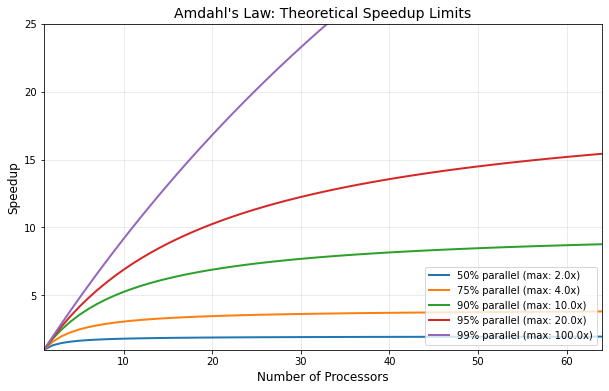

In [11]:
def amdahl_speedup(p, n):
    """Calculate theoretical speedup using Amdahl's Law."""
    return 1 / ((1 - p) + p / n)

# Visualize Amdahl's Law
n_processors = np.arange(1, 65)
parallel_fractions = [0.5, 0.75, 0.9, 0.95, 0.99]

plt.figure(figsize=(10, 6))

for p in parallel_fractions:
    speedups = [amdahl_speedup(p, n) for n in n_processors]
    max_speedup = 1 / (1 - p)
    plt.plot(n_processors, speedups, linewidth=2, 
             label=f'{p*100:.0f}% parallel (max: {max_speedup:.1f}x)')

plt.xlabel('Number of Processors', fontsize=12)
plt.ylabel('Speedup', fontsize=12)
plt.title("Amdahl's Law: Theoretical Speedup Limits", fontsize=14)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.xlim(1, 64)
plt.ylim(1, 25)
plt.show()

---

## 5. Quick Preview: The Two Types of Parallelism

In the next notebooks, we'll explore two different scenarios:

### CPU-Bound Tasks (Notebook 03)
- Heavy calculations
- Use **multiprocessing** (ProcessPoolExecutor)
- Example: Monte Carlo simulations, optimization

### I/O-Bound Tasks (Notebook 02)
- Waiting for external resources
- Use **threading** (ThreadPoolExecutor)
- Example: Fetching data from APIs, reading files

In [12]:
# Quick demo: I/O-bound example (simulated)
def simulate_data_fetch(ticker):
    """Simulate fetching stock data (I/O operation)."""
    time.sleep(0.3)  # Simulate network delay
    # Return fake stock data
    np.random.seed(hash(ticker) % 2**32)
    return {
        'ticker': ticker,
        'price': np.random.uniform(50, 500),
        'volume': np.random.randint(1000000, 10000000)
    }

tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'META', 'NVDA', 'TSLA', 'JPM']

# Sequential
print("Fetching data sequentially...")
start = time.time()
sequential_data = [simulate_data_fetch(t) for t in tickers]
seq_time = time.time() - start
print(f"Sequential time: {seq_time:.2f}s")

# Parallel with threads (good for I/O)
print("\nFetching data with threads...")
start = time.time()
with ThreadPoolExecutor(max_workers=8) as executor:
    parallel_data = list(executor.map(simulate_data_fetch, tickers))
par_time = time.time() - start
print(f"Parallel time: {par_time:.2f}s")
print(f"Speedup: {seq_time/par_time:.2f}x")

Fetching data sequentially...
Sequential time: 2.40s

Fetching data with threads...
Parallel time: 0.30s
Speedup: 7.88x


---

## Summary

### Key Takeaways

1. **Modern CPUs have multiple cores** - your code should use them!

2. **Parallelism works best for independent tasks** - like pricing many options

3. **`concurrent.futures` provides a clean API** - easy to convert sequential code

4. **Amdahl's Law limits speedup** - focus on parallelizing the slow parts

5. **Two types of parallelism**:
   - **CPU-bound**: Use `ProcessPoolExecutor` (multiprocessing)
   - **I/O-bound**: Use `ThreadPoolExecutor` (threading)

### What's Next?

- **Notebook 02**: Deep dive into threading for I/O-bound tasks
- **Notebook 03**: Multiprocessing for CPU-intensive work
- **Notebook 04**: Real-world finance applications
- **Notebook 05**: Hands-on projects

---

## Exercises

Try these on your own:

### Exercise 1: European Put Options
Modify the `price_european_call_sequential` function to price **put options** instead. (Hint: change the payoff from `max(S-K, 0)` to `max(K-S, 0)`)

### Exercise 2: Varying Volatility
Instead of varying strikes, create a function that prices options with different volatility values (e.g., from 10% to 50%). Compare sequential vs parallel performance.

### Exercise 3: Amdahl's Law Calculator
If your sequential code takes 100 seconds, and 80% can be parallelized:
- What's the speedup with 4 cores?
- What's the speedup with 8 cores?
- What's the maximum possible speedup?

In [13]:
# Space for exercises

# Exercise 1: European Put Option
def price_european_put(S0, K, T, r, sigma, n_simulations):
    """Your code here"""
    pass

# Exercise 3: Amdahl's Law
# Use the amdahl_speedup function defined above
p = 0.80  # 80% parallelizable
print(f"Speedup with 4 cores: {amdahl_speedup(p, 4):.2f}x")
print(f"Speedup with 8 cores: {amdahl_speedup(p, 8):.2f}x")
print(f"Maximum speedup (infinite cores): {1/(1-p):.2f}x")

Speedup with 4 cores: 2.50x
Speedup with 8 cores: 3.33x
Maximum speedup (infinite cores): 5.00x
